In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data

# Add parent directory to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from config import config as cfg

In [2]:
import pandas as pd
import seaborn as sns
%matplotlib inline

df_train = pd.read_csv('~/myProjects/fake-news-classifier/datasets/LIAR_PLUS/train2.tsv',
                       sep='\t',
                       header=None,
                       names=('id', 'label', 'statement', 'subjects', 'speaker', 'speaker_title', 'state_info',
                              'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire',
                              'context', 'justification'))

## Missing Data

In [3]:
df_train.head()

,id,label,statement,subjects,speaker,speaker_title,state_info,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [4]:
df_train[df_train.isnull().any(axis=1)].head()

,id,label,statement,subjects,speaker,speaker_title,state_info,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,But determining that would take significant de...
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,But Johnson is correct that many other factors...
12,5947.json,false,When Mitt Romney was governor of Massachusetts...,"history,state-budget",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,an interview with CBN News,NaN


There are 3571 rows with unfilled values  
A lot of data is missing from speaker title and state info.

In [5]:
null_values = df_train.isnull().sum()
print('{}\n'.format(null_values))

id                  0
label               0
statement           0
subjects            2
speaker             2
speaker_title    2897
state_info       2208
party               2
barely_true         2
false               2
half_true           2
mostly_true         2
pants_on_fire       2
context           102
justification      84
dtype: int64



State info has a lot of missing info and is generally irrelevant to fake news.  
So it can be removed

In [6]:
df_train[df_train.isnull().speaker_title]

,id,label,statement,subjects,speaker,speaker_title,state_info,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,But determining that would take significant de...
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,But Johnson is correct that many other factors...
13,8616.json,mostly-true,The economy bled $24 billion due to the govern...,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics,"Doonesbury, aka Garry Trudeau, said the govern..."
17,3863.json,barely-true,"U.S. Rep. Ron Kind, D-Wis., and his fellow Dem...",federal-budget,national-republican-congressional-committee,NaN,NaN,republican,18.0,9.0,8.0,5.0,8.0,a news release,And the debt is a result of tax cuts as well a...
23,2673.json,half-true,"Says Scott Walker favors cutting up to 350,000...","health-care,message-machine",greater-wisconsin-political-fund,NaN,Wisconsin,none,3.0,3.0,3.0,1.0,1.0,a campaign TV ad,"Walker changed course to a muddier position, w..."
37,1038.json,true,The nuclear test conducted in our nation this ...,military,north-korea,NaN,NaN,none,0.0,0.0,0.0,0.0,0.0,a released statement,That means 99. 37 percent of all the tests wer...
38,2940.json,pants-fire,"In the case of a catastrophic event, the Atlan...","health-care,pop-culture",walking-dead,NaN,NaN,none,0.0,0.0,0.0,0.0,1.0,the TV show's season finale,We are pleased to reassure the CDC's neighbors...
41,12027.json,half-true,Says Marco Rubio skipped 18 defense votes incl...,"military,voting-record",keep-promise-1-pac,NaN,NaN,republican,0.0,1.0,1.0,0.0,0.0,a TV ad,"A pro-Cruz PAC said that Marco Rubio ""skipped ..."


In [7]:
df_train[df_train.isnull().context]

,id,label,statement,subjects,speaker,speaker_title,state_info,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
297,610.json,false,On using the Strategic Petroleum Reserve.,energy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,NaN,"Then, the national average for a gallon of gas..."
373,5110.json,pants-fire,"Shes voted for 60 tax increases, hurting the m...",taxes,rob-cornilles,consultant,Oregon,republican,1.0,1.0,3.0,1.0,1.0,NaN,"Still, 16 is a long, long way from 60. We cant..."
380,10931.json,half-true,Since Republicans took over after the 2010 ele...,education,dale-kooyenga,State Representative,Wisconsin,republican,1.0,1.0,2.0,2.0,0.0,NaN,"Likewise, there was a small increase between t..."
392,9784.json,true,On offshore drilling for energy,"energy,voting-record",mark-warner,U.S. Senator,Virginia,democrat,3.0,1.0,6.0,3.0,0.0,NaN,Warners record is consistent: He supports offs...
644,645.json,half-true,Joe Biden brought Republicans and Democrats to...,crime,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,NaN,Obama's language is a little more tempered tha...
824,4544.json,true,On running for the presidency in 2012,elections,chris-christie,Governor of New Jersey,New Jersey,republican,10.0,17.0,27.0,19.0,8.0,NaN,"As a political fund-raiser, Christie pulled in..."
853,12488.json,barely-true,Says Merrick Garland authored an opinion that ...,"foreign-policy,military,supreme-court,terrorism",pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,1.0,0.0,NaN,"Toomey wrote that Garland ""authored an opinion..."
895,97.json,mostly-true,Bill Richardson is the only major Democratic c...,iraq,bill-richardson,Governor,New Mexico,democrat,1.0,2.0,3.0,8.0,1.0,NaN,Kucinich advocates a prompt withdrawal of U. S...
921,10439.json,mostly-true,Assault weapons and handguns are allowed in th...,guns,virginia-house-democratic-caucus,NaN,NaN,democrat,0.0,0.0,0.0,1.0,0.0,NaN,"Calling for reform to Virginias gun laws, Hous..."
1071,630.json,true,On torture.,military,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,37.0,8.0,NaN,We can't torture or treat inhumanely suspected...


In [8]:
df_train[df_train.isnull().justification]

,id,label,statement,subjects,speaker,speaker_title,state_info,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
12,5947.json,false,When Mitt Romney was governor of Massachusetts...,"history,state-budget",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,an interview with CBN News,NaN
98,7258.json,true,"Since 1968, more Americans have died from gunf...",guns,mark-shields,Columnist and commentator,"Washington, D.C.",none,1.0,0.0,0.0,0.0,0.0,the PBS NewsHour,NaN
163,10887.json,half-true,If Milwaukee approves reducing its maximum for...,"city-government,crime,drugs,government-regulat...",robert-puente,NaN,NaN,none,0.0,0.0,1.0,0.0,0.0,remarks to the Milwaukee Common Council,NaN
464,4022.json,barely-true,We do not want to raise anybodys tax rates. Th...,"taxes,abc-news-week",james-clyburn,U.S. Representative,South Carolina,democrat,1.0,1.0,0.0,1.0,0.0,"an interview on ABC's ""This Week with Christia...",NaN
586,5729.json,false,Says abortion doctors are flying into this sta...,"abortion,health-care,public-health",matthew-hill,State Representative,Tennessee,republican,0.0,1.0,0.0,0.0,0.0,a debate on the state House floor.,NaN
689,4983.json,false,Says in 1944 we were in debt more than twice a...,"deficit,economy,federal-budget",rush-holt,NaN,NaN,democrat,0.0,1.0,2.0,1.0,0.0,a telephone town hall meeting,NaN
990,4638.json,false,We saw the president of the United States enga...,"history,military",michele-bachmann,Congresswoman,Minnesota,republican,8.0,22.0,6.0,4.0,16.0,a Republican presidential debate in Las Vegas,NaN
1102,500.json,barely-true,"It doesn't make sense ""historically"" to drop o...",elections,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,"Sioux Falls, S.D.",NaN
1261,9586.json,false,I co-sponsored the Rebuild America Jobs Act fo...,"economy,jobs",jeff-merkley,U.S. Senator,Oregon,democrat,0.0,1.0,3.0,6.0,0.0,an economic issues statement,NaN
1269,13151.json,pants-fire,Say photographs of Hillary Clinton at the deba...,candidates-biography,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,Internet posts,NaN


Strategy:  

Start with complete data (without NaNs)  
Then add some incomplete data slowly

## Top 50 words (raw dataset without NaN)

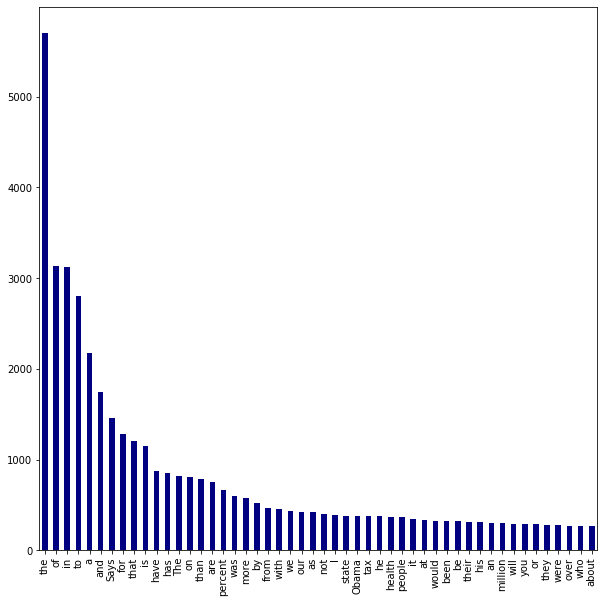

In [139]:
df_train_clean = df_train.dropna()

all_words = df_train_clean.statement.str.split(expand=True).unstack().value_counts()

all_words[:50].plot(kind='bar', figsize=(10, 10), colormap='jet')

In [78]:
ID = data.Field(lower=True, sequential=False)
LABEL = data.Field(lower=True, sequential=False)
TEXT = data.Field(tokenize="spacy")
WORD = data.Field(sequential=False)
COUNT = data.Field(sequential=False, use_vocab=False)

train_set, val_set, test_set = data.TabularDataset.splits(
                                path='~/myProjects/fake-news-classifier/datasets/LIAR_PLUS/',
                                train='train2.tsv',
                                validation='val2.tsv',
                                test='test2.tsv',
                                format='tsv',
                                fields=[('id', None),
                                        ('json_id', None),
                                        ('label', LABEL),
                                        ('statement', TEXT),
                                        ('subjects', None),
                                        ('speaker', None),
                                        ('speaker_title', None),
                                        ('state_info', None),
                                        ('party', None),
                                        ('barely_true', None),
                                        ('false', None),
                                        ('half_true', None),
                                        ('mostly_true', None),
                                        ('pants_on_fire', None),
                                        ('context', None),
                                        ('justification', None)
                                       ]
                               )

TEXT.build_vocab(train_set)
# WORD.build_vocab(train_set)
LABEL.build_vocab(train_set)

# use python -m spacy download en

In [79]:
train_iter, val_iter, test_iter = data.BucketIterator.splits((train_set, val_set, test_set),
                                                             batch_sizes=(1, 4, 4),
                                                             device=cfg.device
                                                            )

In [84]:
ex = train_set[0]
ex.statement

['Says',
 'the',
 'Annies',
 'List',
 'political',
 'group',
 'supports',
 'third',
 '-',
 'trimester',
 'abortions',
 'on',
 'demand',
 '.']

In [88]:
df_train.statement[0]

'Says the Annies List political group supports third-trimester abortions on demand.'

In [89]:
all_words['Says']

1462

'Says the' is present in 185 rows and could affect final result

In [126]:
pants_fire = df_train_clean[df_train_clean.label=='pants-fire'].statement.values
false = df_train_clean[df_train_clean.label=='false'].statement.values
barely_true = df_train_clean[df_train_clean.label=='barely-true'].statement.values
half_true = df_train_clean[df_train_clean.label=='half-true'].statement.values
mostly_true = df_train_clean[df_train_clean.label=='mostly-true'].statement.values
true = df_train_clean[df_train_clean.label=='true'].statement.values

In [127]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color="black", max_words=10000, stopwords=(*STOPWORDS, 'Says'), max_font_size= 40)

(-0.5, 399.5, 199.5, -0.5)

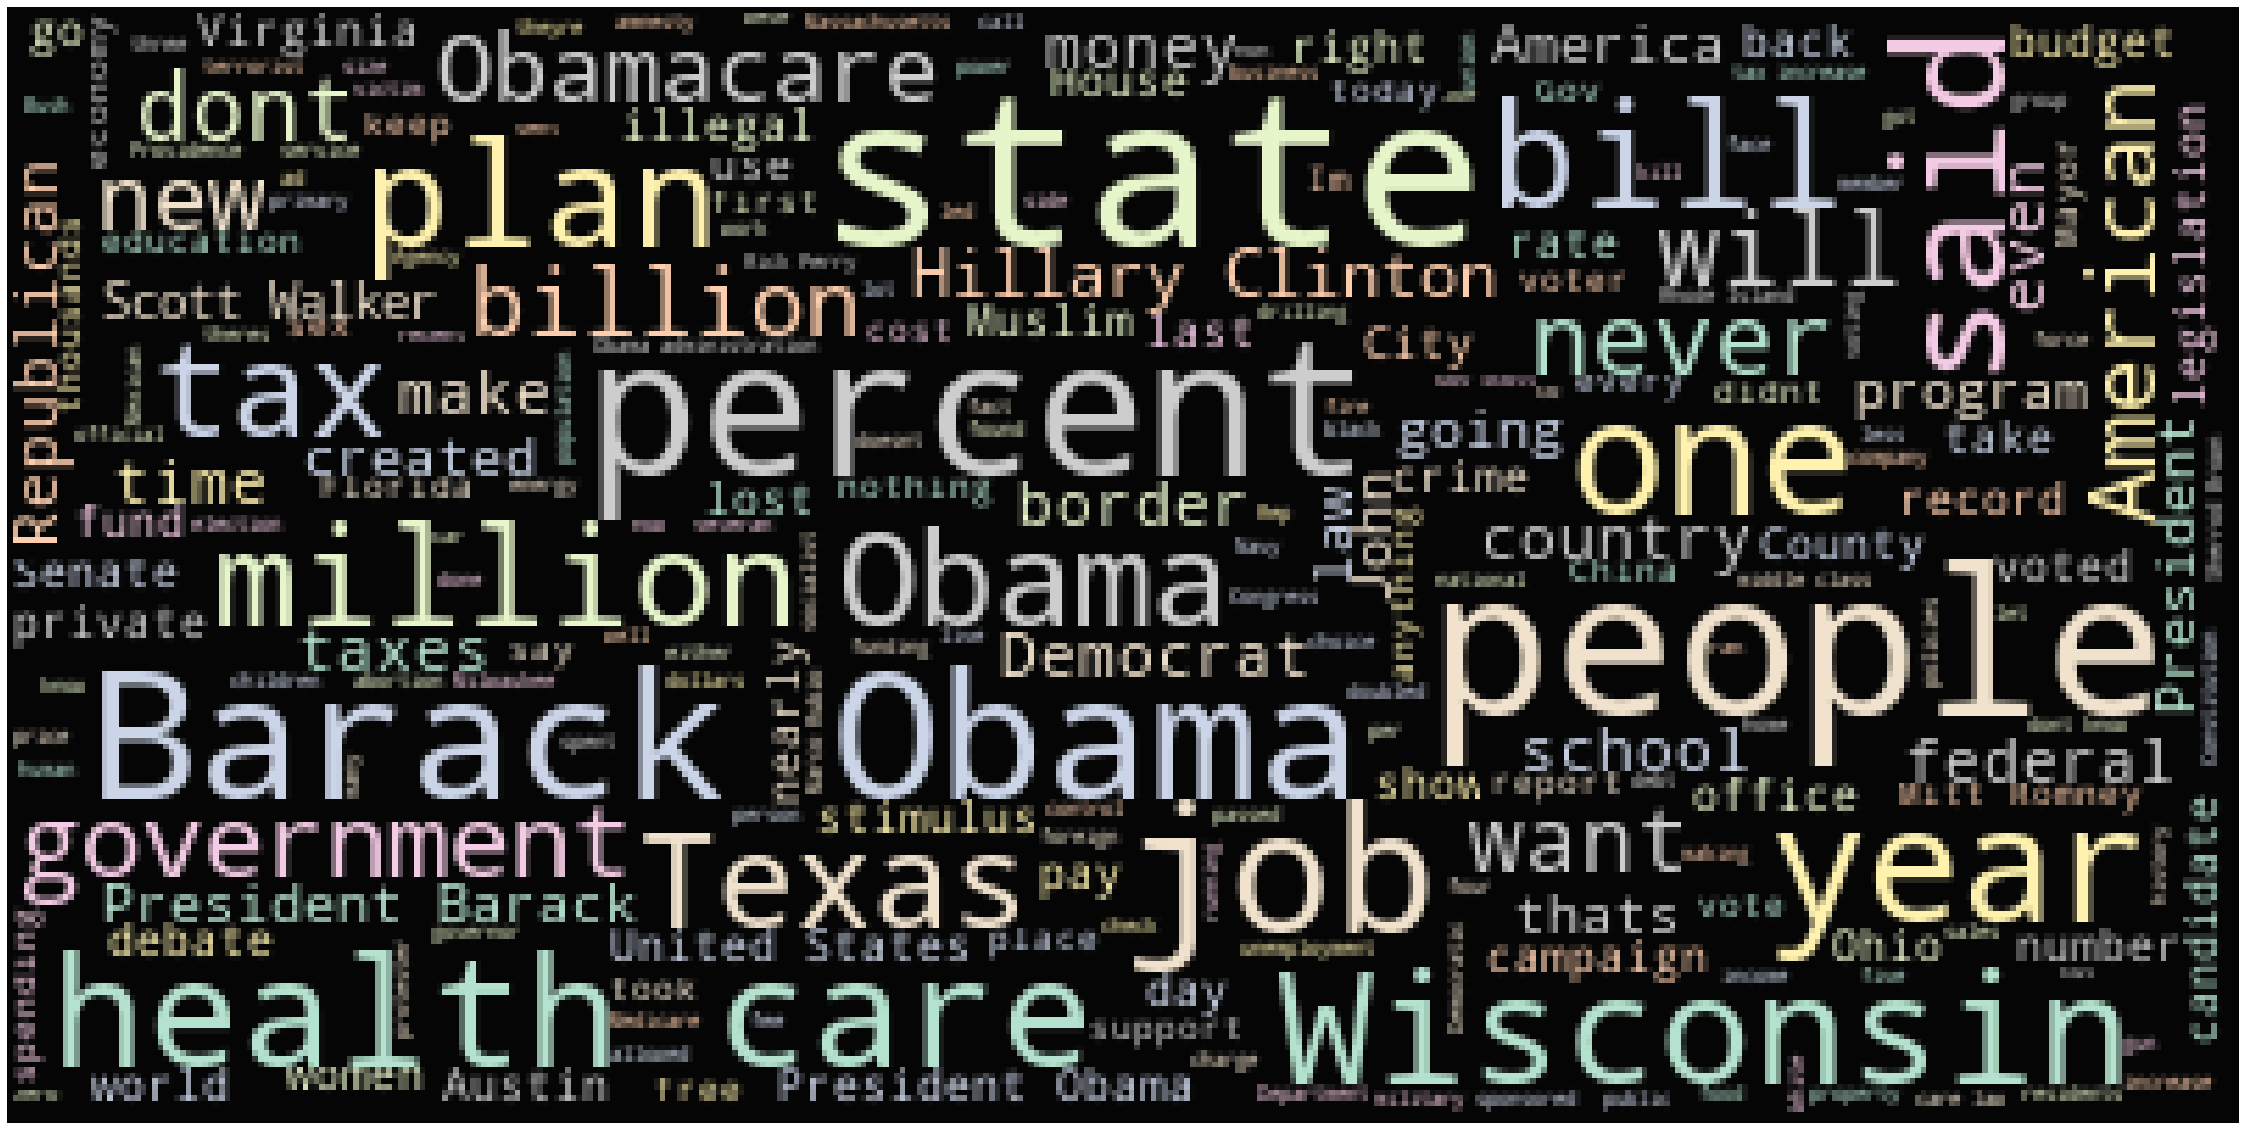

In [128]:
wc.generate(' '.join(pants_fire))
fig, ax = plt.subplots(1, figsize=(40, 40))
ax.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
ax.axis('off')

Say is a huge word in almost all categories

In [141]:
df_train_clean.head()

,id,label,statement,subjects,speaker,speaker_title,state_info,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh..."
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.","However, it was not that bill, but another one..."
